In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
# Import the dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np
import datetime

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, inspect, text, func

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Create engine using the `hawaii.sqlite` database file
#engine = create_engine("sqlite:///SQLAlchemy-Challenge/10-Advanced-SQL/Starter_Code/Resources/hawaii.sqlite")
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# Open the Threads
session = Session(engine) # ORM
conn = engine.connect() # Raw SQL/Pandas

In [5]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
--------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Station = Base.classes.station
measurement = Base.classes.measurement

In [9]:
# Create a session
session = Session(engine) # ORM
conn = engine.connect() # Raw SQL/Pandas

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
query = text("""SELECT max(date) from measurement;""")
conn.execute(query).fetchall()

[('2017-08-23',)]

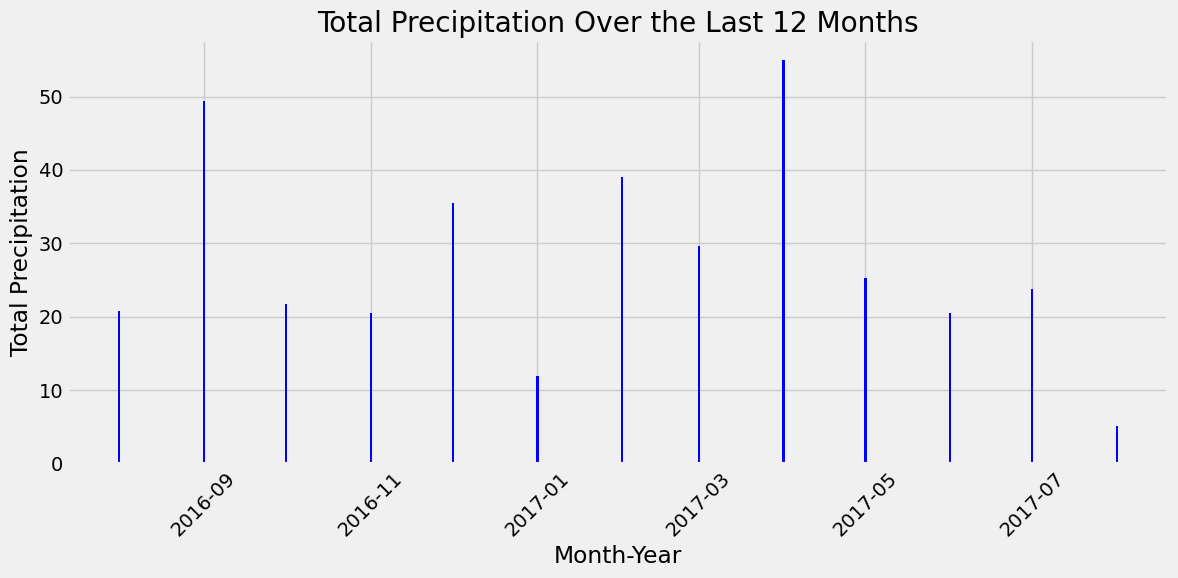

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
query2 = """
SELECT 
    strftime('%Y-%m', date) AS month,
    SUM(prcp) AS total_precipitation
FROM 
    measurement
WHERE 
    date >= date('now', '-12 months')
GROUP BY 
    month
ORDER BY 
    month;
"""

# Calculate the date one year from the last date in data set.
last_date_query = """
SELECT MAX(date) AS last_date
FROM measurement;
"""
last_date_df = pd.read_sql_query(last_date_query, conn)
last_date = last_date_df['last_date'].iloc[0]

one_year_ago = pd.to_datetime(last_date) - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
query_with_date = f"""
SELECT 
    strftime('%Y-%m', date) AS month,
    SUM(prcp) AS total_precipitation
FROM 
    measurement
WHERE 
    date >= '{one_year_ago.strftime('%Y-%m-%d')}'
GROUP BY 
    month
ORDER BY 
    month;
"""

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.read_sql_query(query_with_date, conn)

# Set the column names
precipitation_df.columns = ['month', 'total_precipitation']

# Sort the DataFrame by date (month)
precipitation_df['month'] = pd.to_datetime(precipitation_df['month'])
precipitation_df = precipitation_df.sort_values('month')

# Use Pandas Plotting with Matplotlib to plot the data
# Plotting the results
plt.figure(figsize=(12, 6))
plt.bar(precipitation_df['month'], precipitation_df['total_precipitation'], color='blue')
plt.title('Total Precipitation Over the Last 12 Months')
plt.xlabel('Month-Year')
plt.ylabel('Total Precipitation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate summary statistics
query = """
SELECT 
    date,
    prcp
FROM 
    measurement;
"""

# Save the query results as a Pandas DataFrame
precipitation_df = pd.read_sql_query(query, conn)
summary_statistics = precipitation_df['prcp'].describe()

# Display the summary statistics
print(summary_statistics)

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
query3 = """
SELECT COUNT(DISTINCT station_id) AS total_stations
FROM stations;
"""
total_stations_df = pd.read_sql_query(query, conn)

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query4 = """
SELECT 
    station, 
    COUNT(*) AS station_count
FROM 
    measurement
GROUP BY 
    station
ORDER BY 
    station_count DESC;
"""

# Execute the query and save the result as a Pandas DataFrame
most_active_stations_df = pd.read_sql_query(query4, conn)

# Display the most active stations
print(most_active_stations_df)

       station  station_count
0  USC00519281           2772
1  USC00519397           2724
2  USC00513117           2709
3  USC00519523           2669
4  USC00516128           2612
5  USC00514830           2202
6  USC00511918           1979
7  USC00517948           1372
8  USC00518838            511


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# SQL query to calculate the lowest, highest, and average temperature for the most active station
# Step 1: Query to find the most active station
most_active_station_query = """
SELECT 
    station, 
    COUNT(*) AS station_count
FROM 
    measurement
GROUP BY 
    station
ORDER BY 
    station_count DESC;
"""


# Execute the query and get the most active station ID
most_active_station_df = pd.read_sql_query(most_active_station_query, conn)
most_active_station_id = most_active_station_df['station'].iloc[0]  # Get the station ID

# Step 2: SQL query to calculate the lowest, highest, and average temperature for the most active station
query5 = f"""
SELECT 
    MIN(tobs) AS lowest_temperature,
    MAX(tobs) AS highest_temperature,
    AVG(tobs) AS average_temperature
FROM 
    measurement
WHERE 
    station = 'USC00519281';
"""

# Step 3: Execute the query and save the result as a Pandas DataFrame
temperature_stats_df = pd.read_sql_query(query5, conn)

# Display the temperature statistics
print(temperature_stats_df)

   lowest_temperature  highest_temperature  average_temperature
0                54.0                 85.0            71.663781


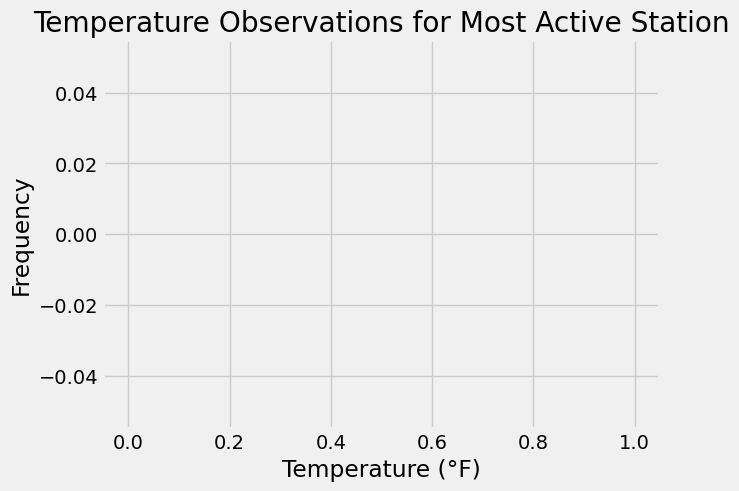

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query6 = """
SELECT tobs
FROM measurement
WHERE station = 'USC00519281'
AND date >= DATE('now', '-12 months');
"""
# Execute the query and store the results in a DataFrame
df = pd.read_sql(query6, engine)

# Plotting the histogram
plt.hist(df['tobs'], bins=30, color='blue', alpha=0.7)
plt.title('Temperature Observations for Most Active Station')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [27]:
# Close Session
session.close()
